In [4]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import seaborn as sns
import torch
import warnings
from catboost import CatBoostClassifier
from functools import lru_cache
from gensim.models import Word2Vec, word2vec
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,
                             classification_report, roc_auc_score)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from skimage.io import imread
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from torch.autograd import Variable
from torch.nn import (BCELoss, BatchNorm2d, Conv2d, CrossEntropyLoss, Dropout,
                      Linear, MaxPool2d, Module, ReLU, Sequential, Softmax)
from torch.optim import Adam, SGD
from tqdm import tqdm

np.random.seed(42)
random.seed(42)
warnings.filterwarnings("ignore")
%matplotlib inline


In [6]:
nltk.download('stopwords')

In [3]:
df = pd.read_csv('df_clean.csv')

In [4]:
df.head()

,address,name,rating,rubrics,text,aspects,target,word_pre
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.0,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...,квартал лето ночь гонка стройка окно этаж райо...,1,московский квартал \nшумно лето ночь дикий гон...
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.0,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...",сеть магазин ассортимент цена главное качество...,2,замечательный сеть магазин общий хороший ассор...
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.0,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...",правило шкаф замочка отпечаток палец дичь подп...,0,знать смутить дать правило удивить хотеть твой...
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.0,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,условие аренда персонал ботинок крепление сноу...,2,хороший условие аренда \nдружелюбный персонал ...
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.0,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,топ топ смысл посещение бровь ресница итог раб...,2,мастер ангелина весь смысл немного волноваться...


уберем '\n'

In [5]:
def cleann_text(row):
    return re.sub(r'\\|n', '', row)
df = df.dropna(subset=['word_pre'])
df['word_pre'] = df['word_pre'].apply(lambda x: cleann_text(x))

In [6]:
df['word_tokens'] = df['word_pre'].apply(nltk.word_tokenize)

In [7]:
df.head()

,address,name,rating,rubrics,text,aspects,target,word_pre,word_tokens
0,"Екатеринбург, ул. Московская / ул. Волгоградск...",Московский квартал,3.0,Жилой комплекс,Московский квартал 2.\nШумно : летом по ночам ...,квартал лето ночь гонка стройка окно этаж райо...,1,московский квартал шумно лето ночь дикий гонка...,"[московский, квартал, шумно, лето, ночь, дикий..."
1,"Московская область, Электросталь, проспект Лен...",Продукты Ермолино,5.0,Магазин продуктов;Продукты глубокой заморозки;...,"Замечательная сеть магазинов в общем, хороший ...",сеть магазин ассортимент цена главное качество...,2,замечательный сеть магазин общий хороший ассор...,"[замечательный, сеть, магазин, общий, хороший,..."
2,"Краснодар, Прикубанский внутригородской округ,...",LimeFit,1.0,Фитнес-клуб,"Не знаю смутят ли кого-то данные правила, но я...",правило шкаф замочка отпечаток палец дичь подп...,0,знать смутить дать правило удивить хотеть твой...,"[знать, смутить, дать, правило, удивить, хотет..."
3,"Санкт-Петербург, проспект Энгельса, 111, корп. 1",Snow-Express,4.0,Пункт проката;Прокат велосипедов;Сапсёрфинг,Хорошие условия аренды. \nДружелюбный персонал...,условие аренда персонал ботинок крепление сноу...,2,хороший условие аренда дружелюбный персонал ны...,"[хороший, условие, аренда, дружелюбный, персон..."
4,"Тверь, Волоколамский проспект, 39",Студия Beauty Brow,5.0,"Салон красоты;Визажисты, стилисты;Салон бровей...",Топ мастер Ангелина топ во всех смыслах ) Немн...,топ топ смысл посещение бровь ресница итог раб...,2,мастер ангелина весь смысл немного волноваться...,"[мастер, ангелина, весь, смысл, немного, волно..."


In [8]:
df.to_csv('df.csv')

In [9]:
def split_train_test(data_context_copy, test_size=0.25, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(df['word_tokens'], 
                                                        df['target'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = split_train_test(df)

Value counts for Train sentiments
2    37506
0    34929
1    16230
Name: target, dtype: int64
Value counts for Test sentiments
2    12493
0    11640
1     5422
Name: target, dtype: int64
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
   index                                        word_tokens
0  48464  [отличный, магазин, широкий, выбор, свежий, то...
1  99422  [заказать, компьютерный, стол, плюс, мебель, к...
2   3383  [очень, классный, красивый, заведение, отмечат...
3  60737  [дополнять, свой, отзыв, сожаление, изменение,...
4  86503  [очень, посредственный, бургерный, обратить, в...


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [11]:
OUTPUT_FOLDER = os.getcwd()

In [12]:
size = 500
window = 5
min_count = 1
workers = 3
sg = 1


def make_word2vec_model(top_data_df_small, padding=True, sg=1, min_count=1, size=300, workers=3, window=5):
    if  padding:
        print(len(top_data_df_small))
        temp_df = pd.Series(df['word_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file = OUTPUT_FOLDER + 'models' + 'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = df['word_tokens']
        word2vec_file = OUTPUT_FOLDER + 'models' + 'word2vec_' + str(size) + '.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, vector_size = size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file


w2vmodel, word2vec_file = make_word2vec_model(df, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

118220


In [13]:
max_sen_len = df.word_tokens.map(len).max()
padding_idx = padding_idx = w2vmodel.wv.key_to_index['pad']
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.key_to_index:
            padded_X[i] = 0
            print(word)
        else:
            padded_X[i] =  w2vmodel.wv.key_to_index[word]
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

In [14]:
def make_target(label):
    if label == 0:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 1:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [15]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 20
import gensim

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load(OUTPUT_FOLDER + 'models' + 'word2vec_500_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx= w2vmodel.wv.key_to_index['pad'])
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [16]:
NUM_CLASSES = 3
VOCAB_SIZE = len(w2vmodel.wv.key_to_index)


cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=3)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_model.parameters(), lr=1e-4)
num_epochs = 3


loss_file_name = OUTPUT_FOLDER +  'plots' + 'cnn_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
cnn_model.train()
for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    train_loss = 0
    for index, row in X_train.iterrows():
        cnn_model.zero_grad()
        bow_vec = make_word2vec_vector_cnn(row['word_tokens'])
        probs = cnn_model(bow_vec)
        target = make_target(Y_train['target'][index])
        loss = loss_function(probs, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()


    # if index == 0:
    #     continue
    print("Epoch ran :"+ str(epoch+1))
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

torch.save(cnn_model, OUTPUT_FOLDER + 'cnn_big_model_500_with_padding.pth')

f.close()
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(probs)
print(torch.argmax(probs, dim=1).cpu().numpy()[0])

Epoch1
Epoch ran :1
Epoch2
Epoch ran :2
Epoch3
Epoch ran :3
Input vector
[[    1     6 45002 ... 97668 97668 97668]]
Probs
tensor([[9.9328e-01, 6.6993e-03, 2.3150e-05]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
0


In [17]:
cnn_model.eval()
file_path = ""
loss_df = pd.read_csv(file_path)
print(loss_df.columns)

# Используйте CrossEntropyLoss для многоклассовой классификации
criterion = torch.nn.CrossEntropyLoss()

bow_cnn_predictions = []
original_labels_cnn_bow = []

cnn_model.eval()


with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_word2vec_vector_cnn(row['word_tokens'])
        probs = cnn_model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
        original_labels_cnn_bow.append(Y_test['target'][index])  

f1_score(original_labels_cnn_bow, bow_cnn_predictions, average='macro')

Index(['iter', ' loss'], dtype='object')


0.7471324222271051

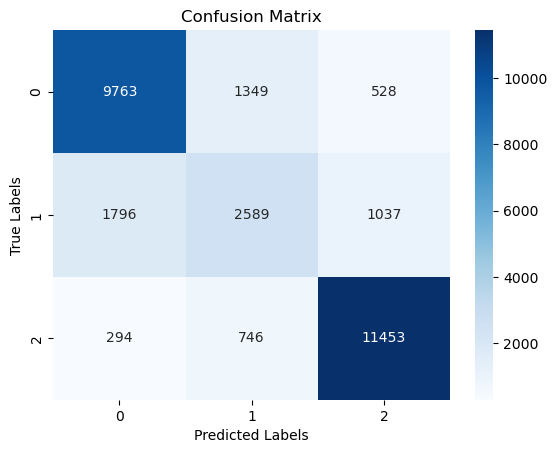

In [18]:
confusion_mat = confusion_matrix(Y_test['target'], bow_cnn_predictions)
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()